In [70]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [71]:
csv_path = "coffee.csv"
df = pd.read_csv(csv_path)
date_time = pd.to_datetime(df.pop('Date'), format='%Y-%m-%d')
timestamp_s = date_time.map(datetime.datetime.timestamp)

df

,Open,High,Low,Close,Volume
0,122.25,124.00,116.10,116.50,6640
1,116.25,120.50,115.75,116.25,5492
2,115.00,121.00,115.00,118.60,6165
3,119.00,121.40,116.50,116.85,5094
4,117.25,117.75,113.80,114.15,6855
...,...,...,...,...,...
5741,240.55,240.55,240.55,240.50,1
5742,238.75,241.75,238.75,239.15,14
5743,240.75,240.75,239.65,239.10,12
5744,238.55,238.55,236.60,236.35,6


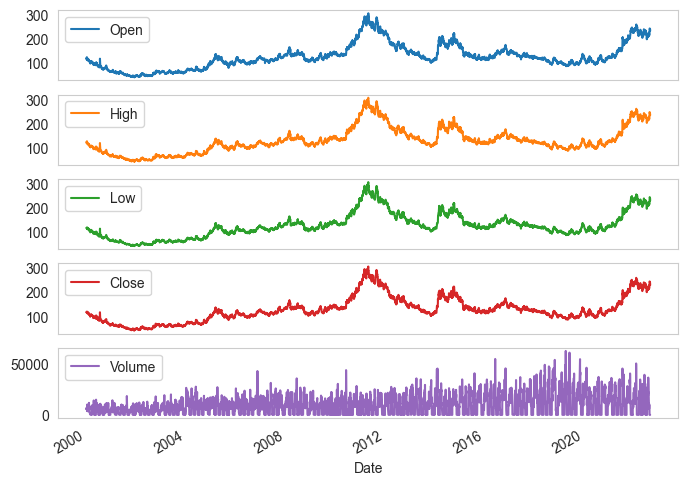

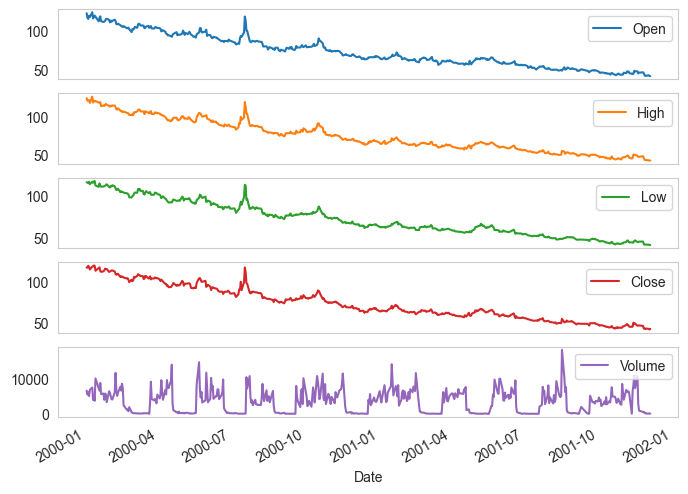

In [72]:
plot_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [73]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,5746.0,127.267635,50.569425,41.5,98.8000,120.40,144.8000,305.30
High,5746.0,128.847034,51.164948,42.0,100.1125,121.60,146.0000,306.25
Low,5746.0,125.784669,49.851487,41.5,97.8625,118.95,143.0000,304.00
Close,5746.0,127.215567,50.506519,41.5,98.6500,120.25,144.3375,304.90
Volume,5746.0,8807.178907,9612.789034,0.0,61.0000,7008.00,14497.7500,62045.00


In [74]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [75]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

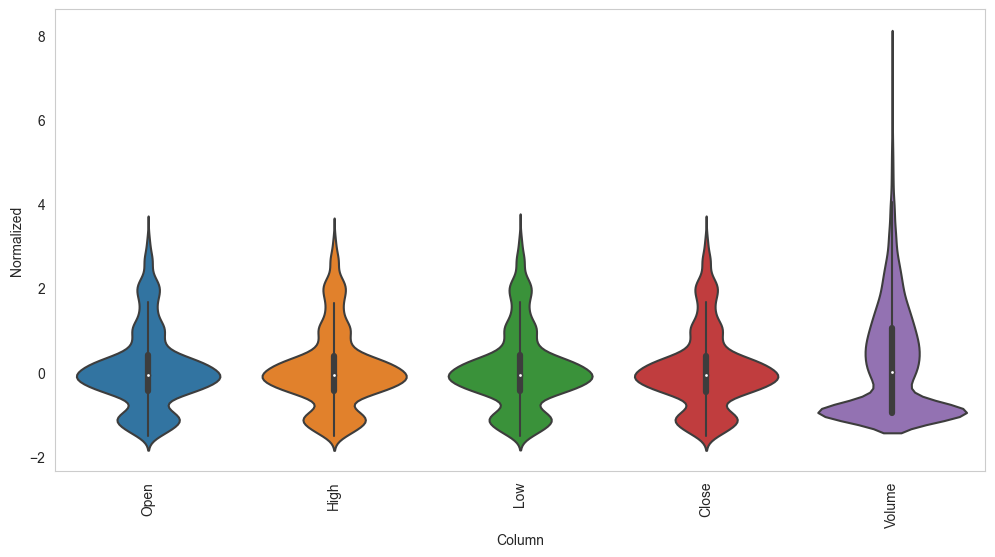

In [76]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [77]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [78]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [79]:
w1 = WindowGenerator(input_width=30, label_width=1, shift=30,
                     label_columns=['Open', 'High', 'Low', 'Close', 'Volume'])
w1

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [59]
Label column name(s): ['Open', 'High', 'Low', 'Close', 'Volume']

In [80]:
def plot(self, model=None, plot_col='Open', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot

In [81]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [82]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# Одноступенчатая модель

In [83]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Open'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Open']

In [84]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [117]:
baseline = Baseline(label_index=column_indices['Open'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

36/36 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0315


In [118]:
wide_window = WindowGenerator(
    input_width=30, label_width=30, shift=1,
    label_columns=['Open'])

wide_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['Open']

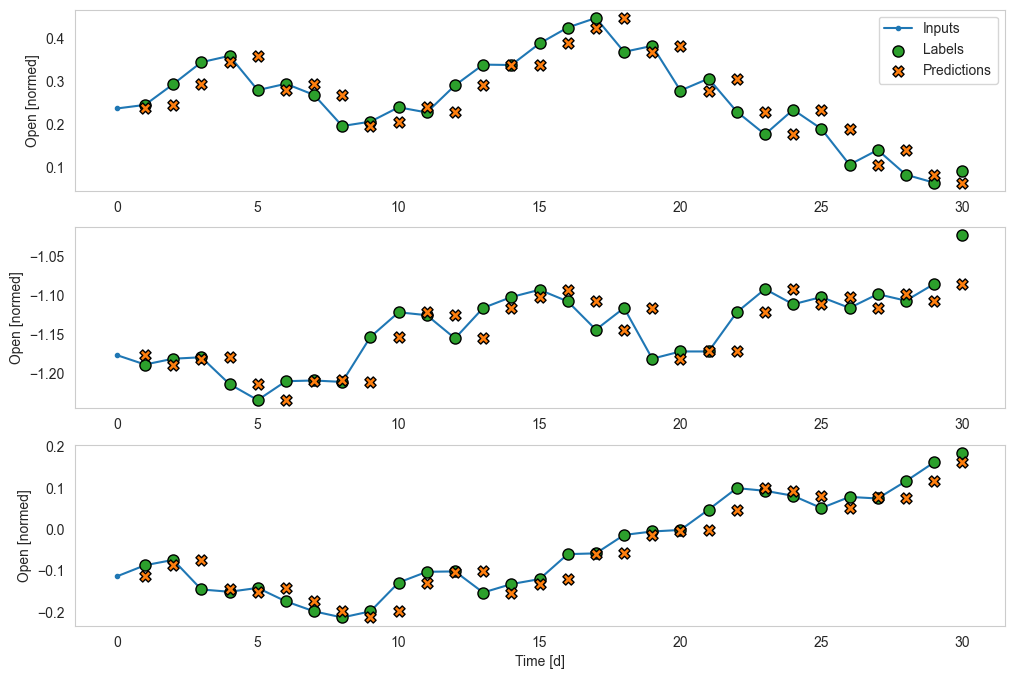

In [119]:
wide_window.plot(baseline)

# Линейная Модель

In [120]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [121]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [122]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/100
126/126 [==============================] - 1s 5ms/step - loss: 0.3416 - mean_absolute_error: 0.4524 - val_loss: 0.3035 - val_mean_absolute_error: 0.4265
Epoch 2/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0812 - mean_absolute_error: 0.2198 - val_loss: 0.1154 - val_mean_absolute_error: 0.2684
Epoch 3/100
126/126 [==============================] - 0s 1ms/step - loss: 0.0203 - mean_absolute_error: 0.1092 - val_loss: 0.0366 - val_mean_absolute_error: 0.1515
Epoch 4/100
126/126 [==============================] - 0s 1ms/step - loss: 0.0067 - mean_absolute_error: 0.0612 - val_loss: 0.0104 - val_mean_absolute_error: 0.0800
Epoch 5/100
126/126 [==============================] - 0s 1ms/step - loss: 0.0033 - mean_absolute_error: 0.0416 - val_loss: 0.0036 - val_mean_absolute_error: 0.0467
Epoch 6/100
126/126 [==============================] - 0s 1ms/step - loss: 0.0026 - mean_absolute_error: 0.0358 - val_loss: 0.0021 - val_mean_absolute_error: 0.0361
Epoch 7/10

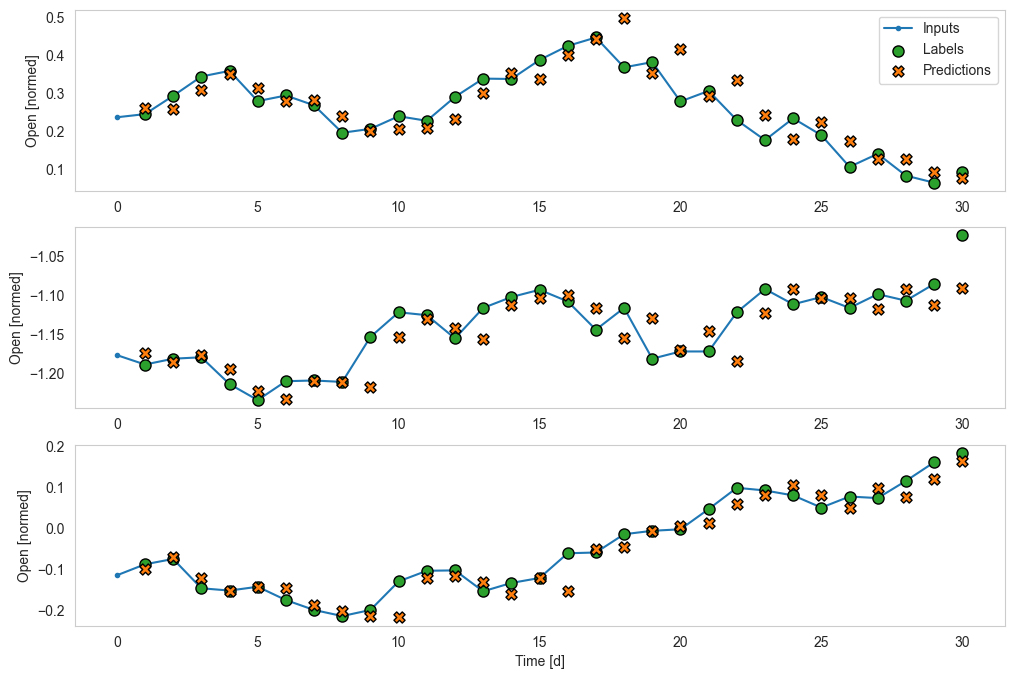

In [123]:
wide_window.plot(linear)

# Полносвязная

In [124]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/100
126/126 [==============================] - 1s 2ms/step - loss: 0.0512 - mean_absolute_error: 0.1001 - val_loss: 0.0020 - val_mean_absolute_error: 0.0335
Epoch 2/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0012 - mean_absolute_error: 0.0250 - val_loss: 8.5433e-04 - val_mean_absolute_error: 0.0219
Epoch 3/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0011 - mean_absolute_error: 0.0228 - val_loss: 8.1442e-04 - val_mean_absolute_error: 0.0211
Epoch 4/100
126/126 [==============================] - 0s 2ms/step - loss: 9.7574e-04 - mean_absolute_error: 0.0215 - val_loss: 7.3047e-04 - val_mean_absolute_error: 0.0195
Epoch 5/100
126/126 [==============================] - 0s 2ms/step - loss: 9.7182e-04 - mean_absolute_error: 0.0215 - val_loss: 8.4181e-04 - val_mean_absolute_error: 0.0221
Epoch 6/100
126/126 [==============================] - 0s 2ms/step - loss: 8.8124e-04 - mean_absolute_error: 0.0203 - val_loss: 5.9320e-04 - val_mean_a

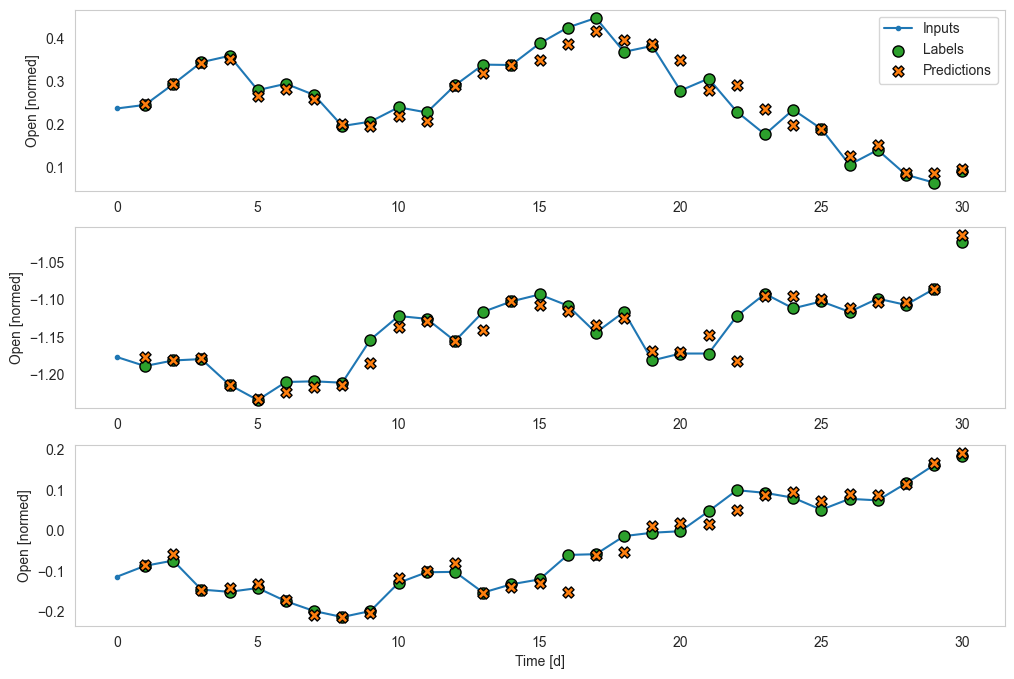

In [125]:
wide_window.plot(dense)

In [126]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Open'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Open']

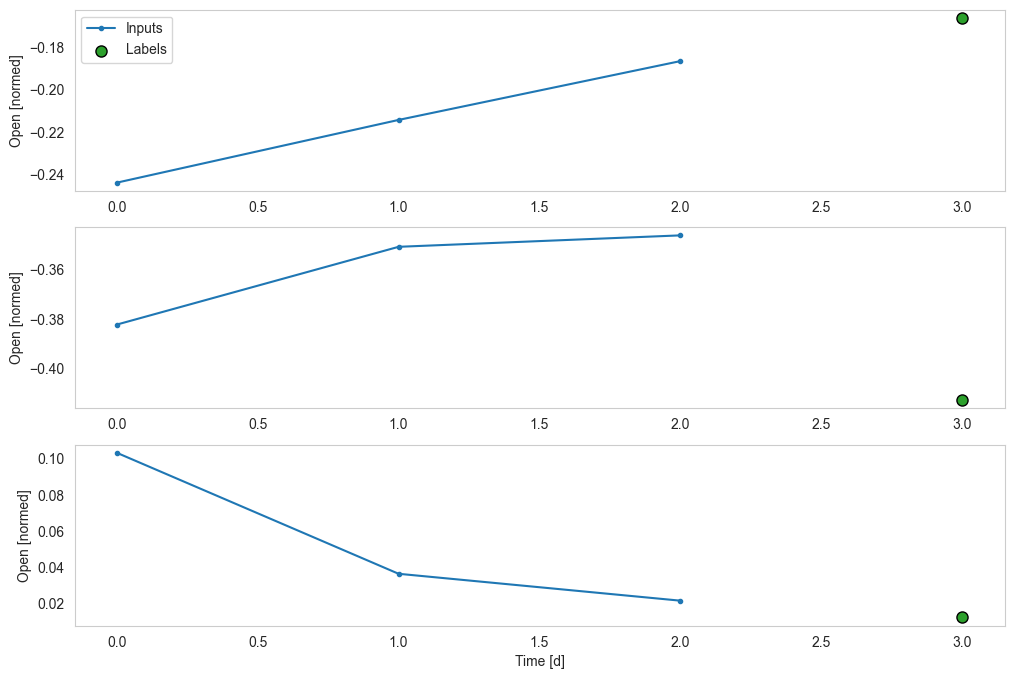

In [127]:
conv_window.plot()

In [128]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [129]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

36/36 [==============================] - 0s 816us/step - loss: 0.0012 - mean_absolute_error: 0.0263


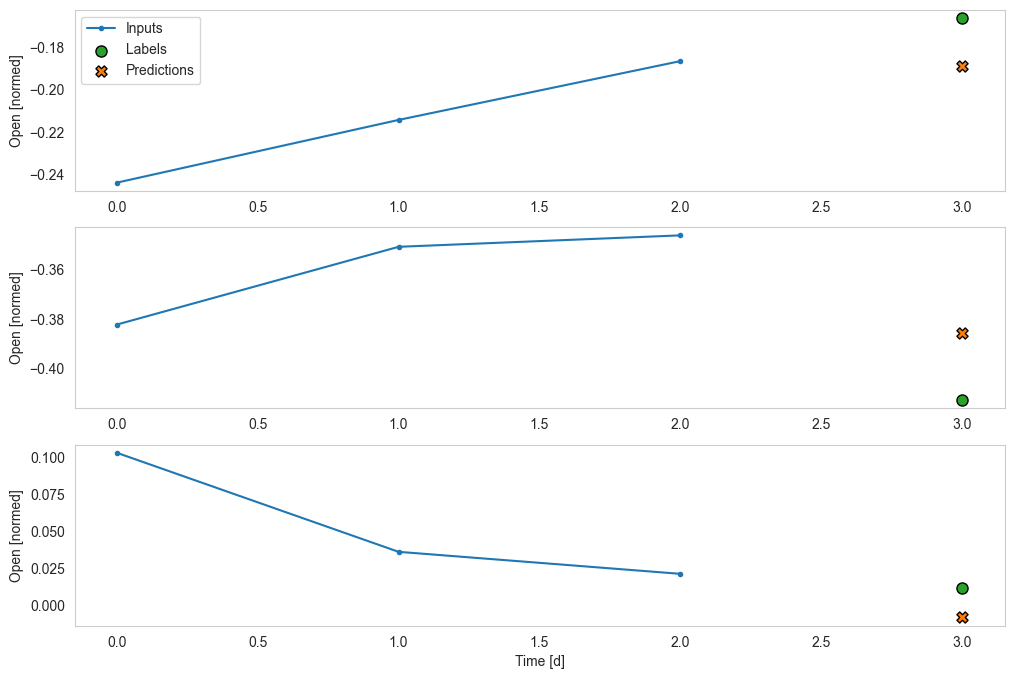

In [130]:
conv_window.plot(multi_step_dense)

# Сверточная нейронная сеть

In [131]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [132]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

36/36 [==============================] - 0s 835us/step - loss: 0.0016 - mean_absolute_error: 0.0307


In [133]:
LABEL_WIDTH = 30
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Open'])

wide_conv_window

Total window size: 33
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32]
Label column name(s): ['Open']

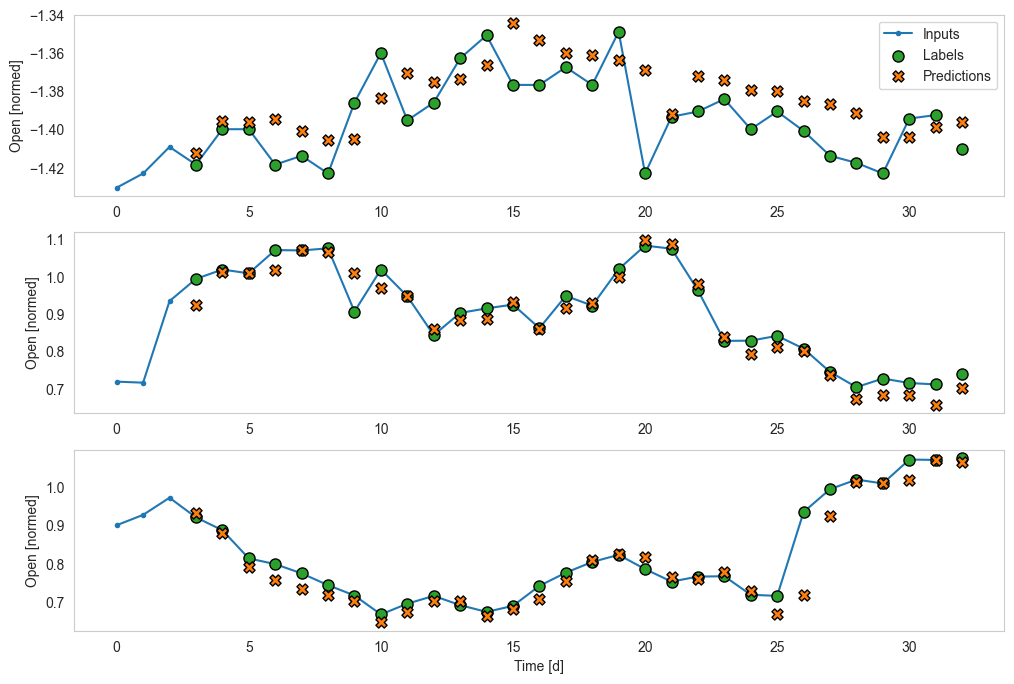

In [134]:
wide_conv_window.plot(conv_model)

Рекуррентная нейронная сеть

In [135]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [136]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

35/35 [==============================] - 0s 5ms/step - loss: 5.5672e-04 - mean_absolute_error: 0.0166


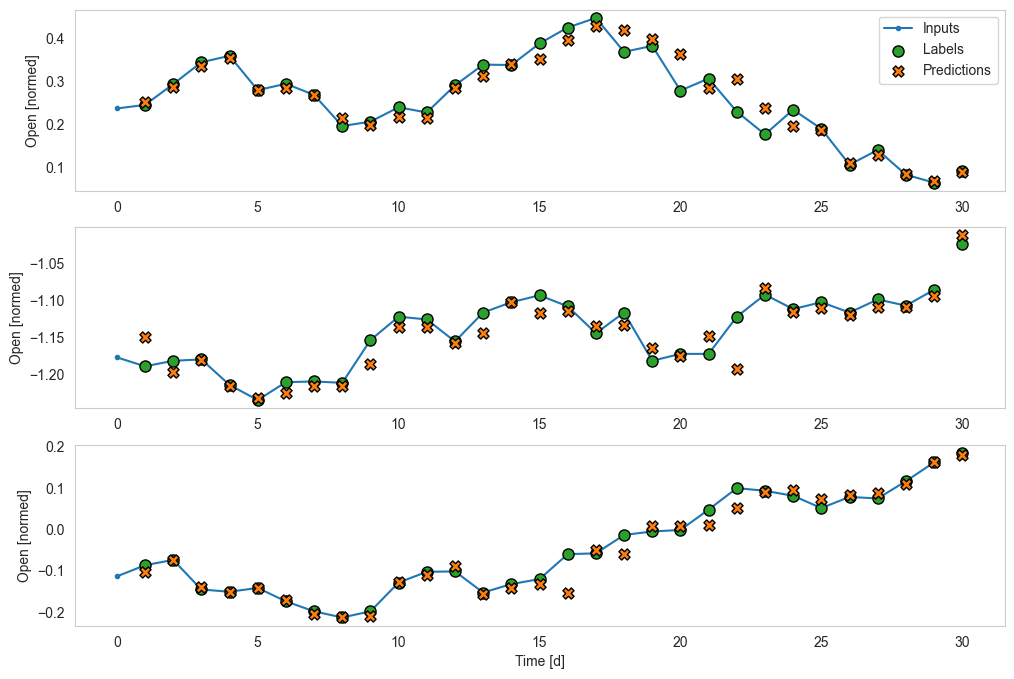

In [137]:
wide_window.plot(lstm_model)

# Сравнение

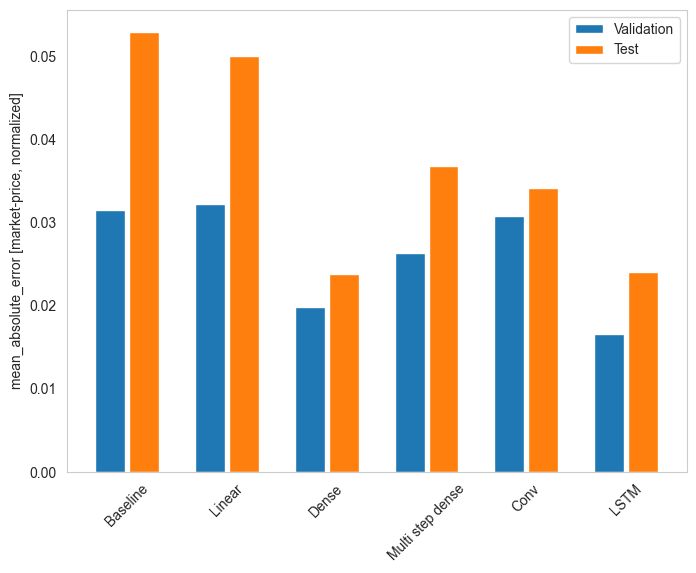

In [138]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [market-price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [139]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

performance

Baseline    : 0.0529
Linear      : 0.0501
Dense       : 0.0238
Multi step dense: 0.0367
Conv        : 0.0342
LSTM        : 0.0240


{'Baseline': [0.005308498628437519, 0.05291987583041191],
 'Linear': [0.004797371570020914, 0.05007634311914444],
 'Dense': [0.001212181057780981, 0.023755185306072235],
 'Multi step dense': [0.0024393738713115454, 0.03673102334141731],
 'Conv': [0.0020197033882141113, 0.0341639369726181],
 'LSTM': [0.001486623426899314, 0.0239975955337286]}

# Многошаговые модели

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

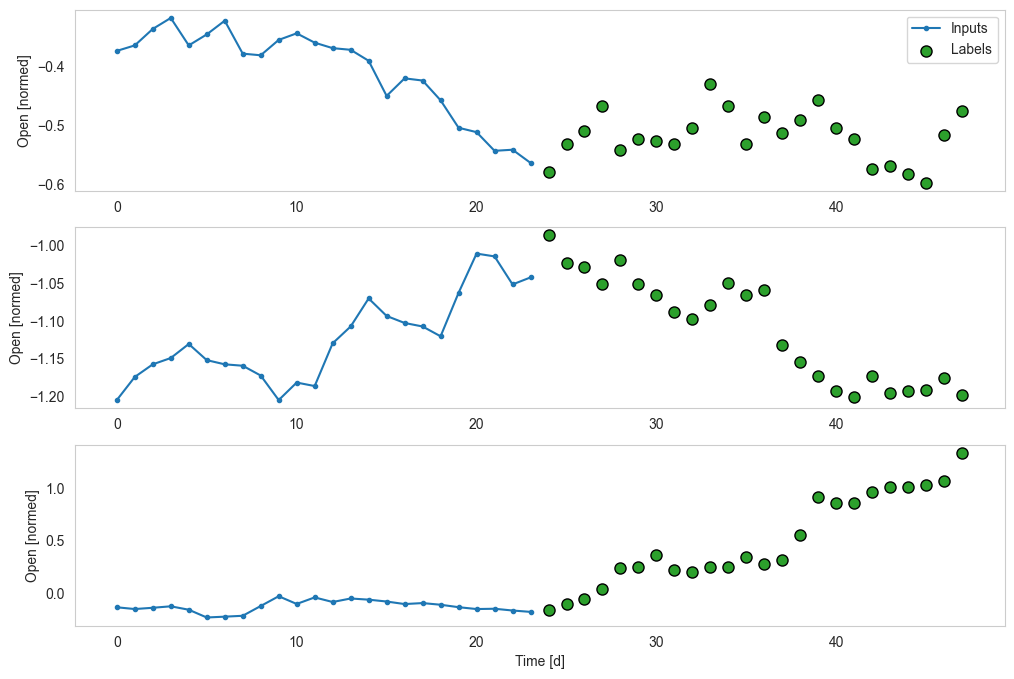

In [140]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

35/35 [==============================] - 0s 913us/step - loss: 1.3280 - mean_absolute_error: 0.4728


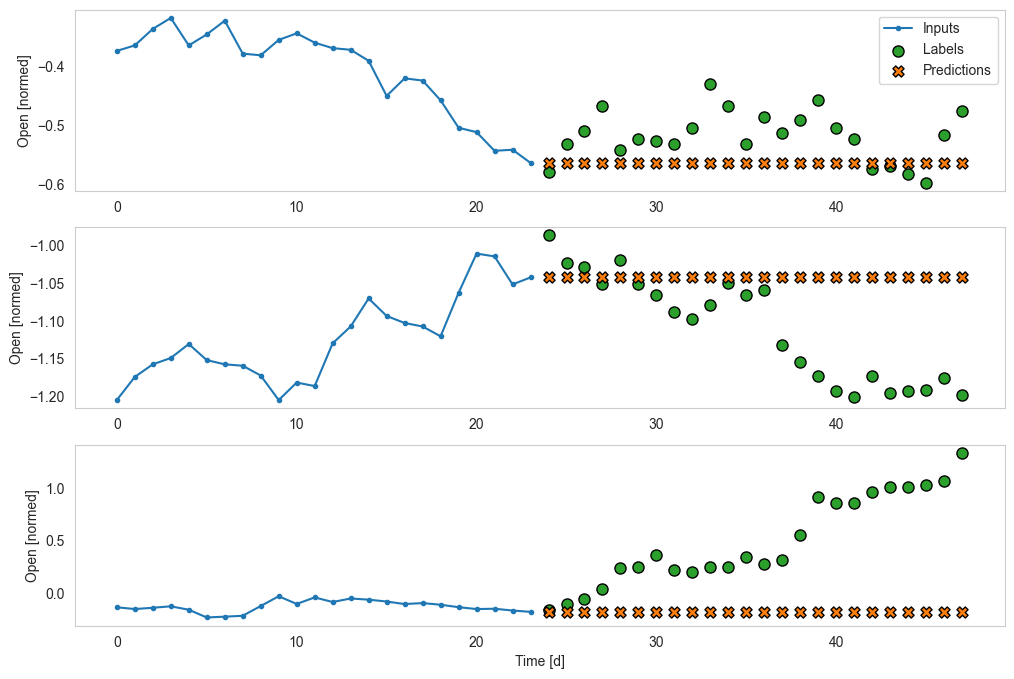

In [141]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

# Повторение предыдущего периода

35/35 [==============================] - 0s 1ms/step - loss: 2.0936 - mean_absolute_error: 0.6785


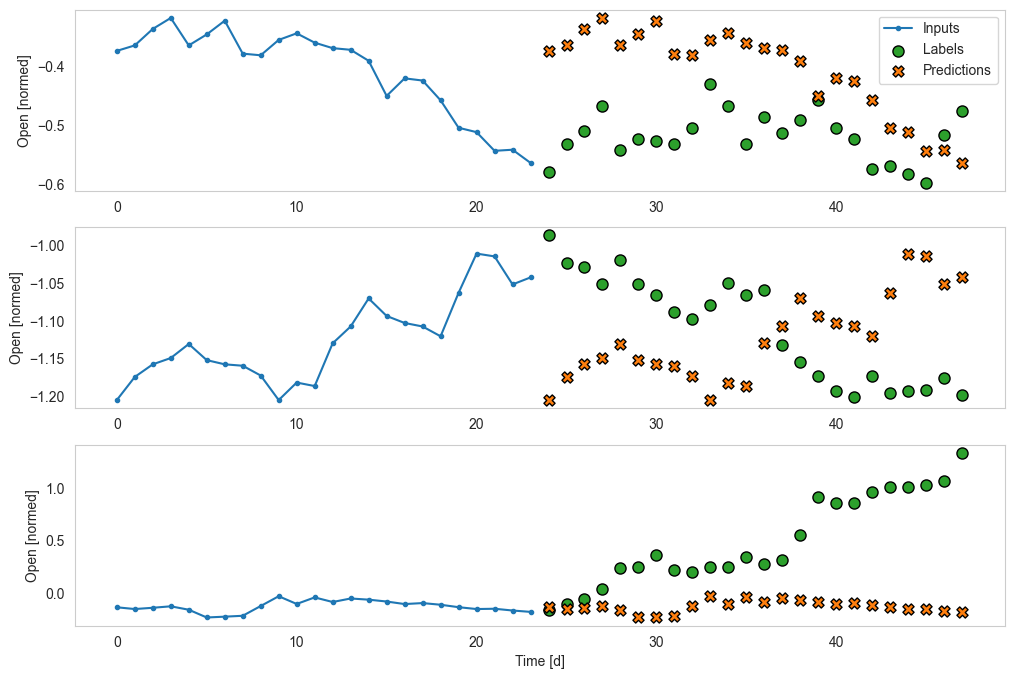

In [142]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

# Одноразрядные модели

    Линейная

35/35 [==============================] - 0s 1ms/step - loss: 0.7417 - mean_absolute_error: 0.3733


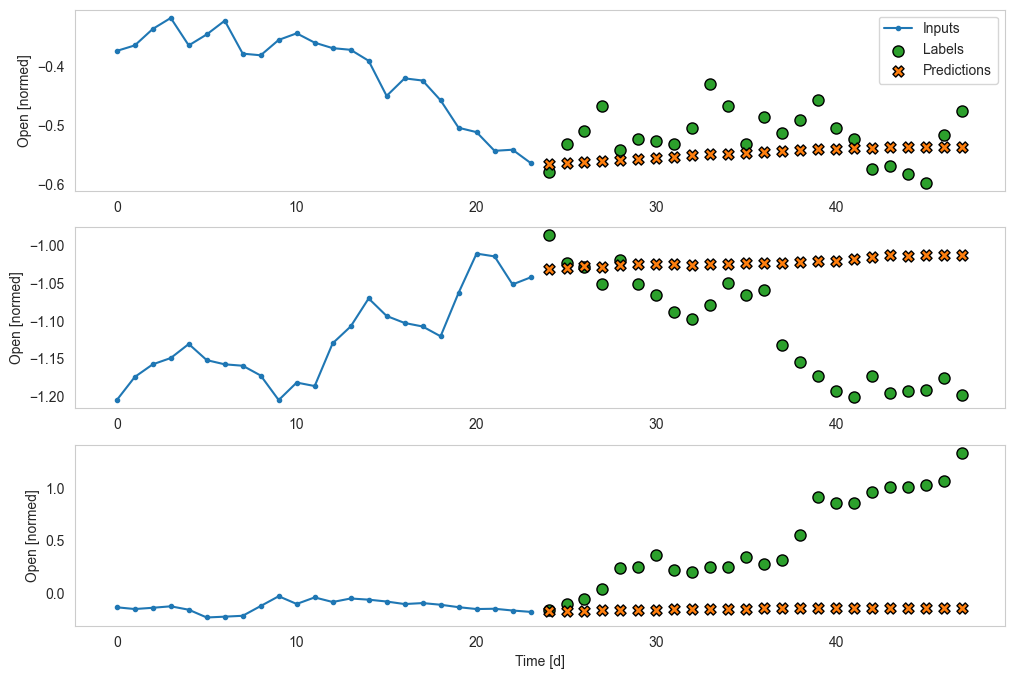

In [143]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

    Полносвязная модель

35/35 [==============================] - 0s 1ms/step - loss: 0.7000 - mean_absolute_error: 0.3743


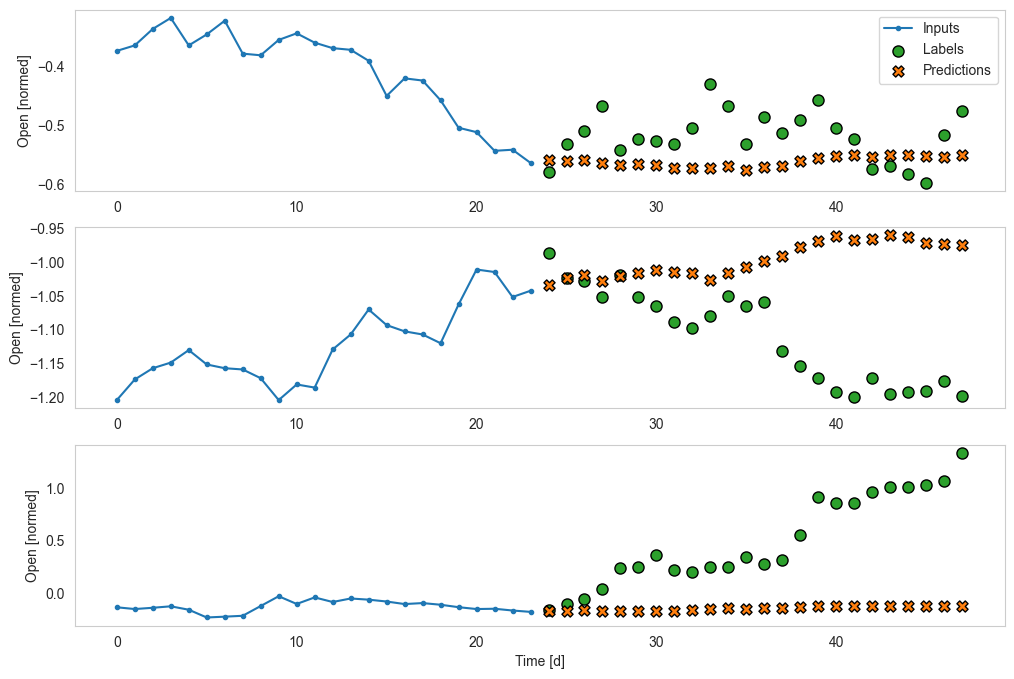

In [144]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

    SNN

35/35 [==============================] - 0s 1ms/step - loss: 0.7071 - mean_absolute_error: 0.3624


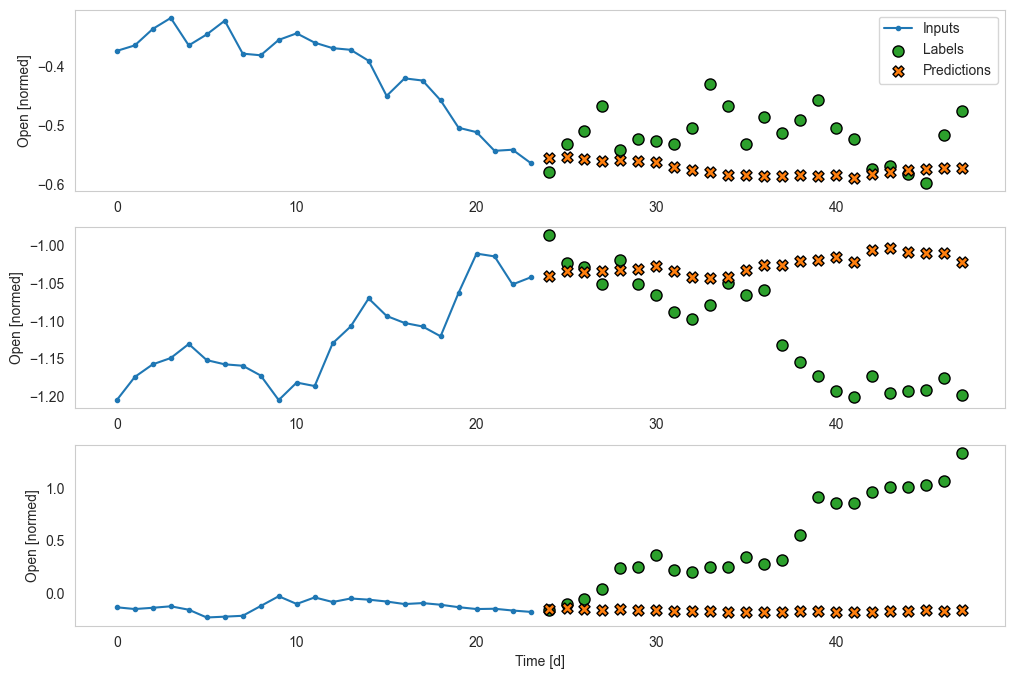

In [145]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

    PHH

35/35 [==============================] - 0s 2ms/step - loss: 0.6209 - mean_absolute_error: 0.3541


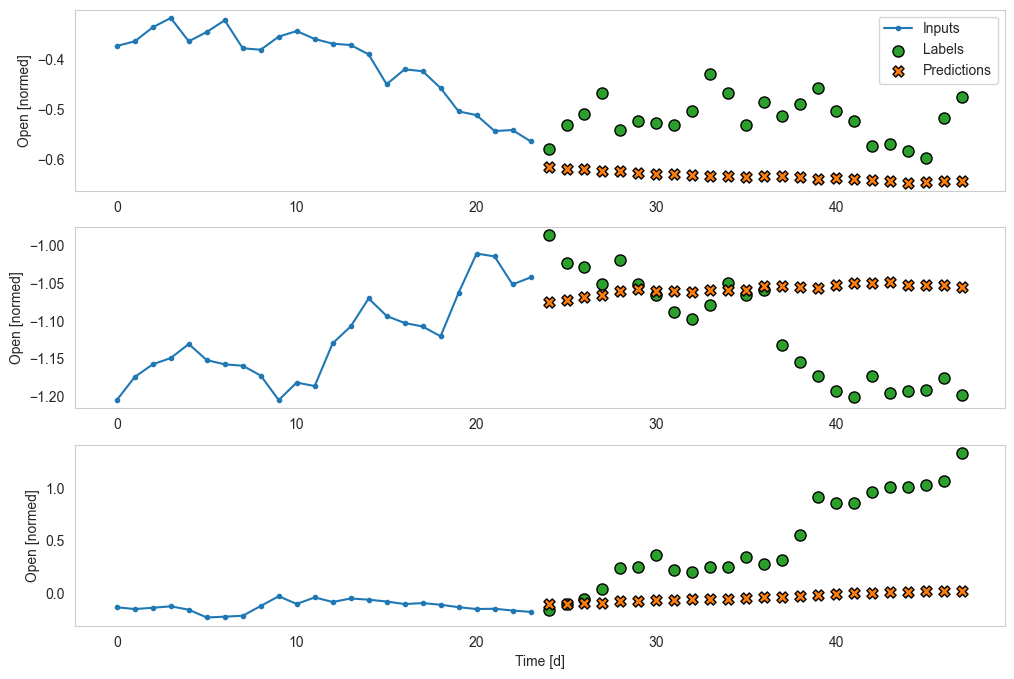

In [146]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

# Сравнение

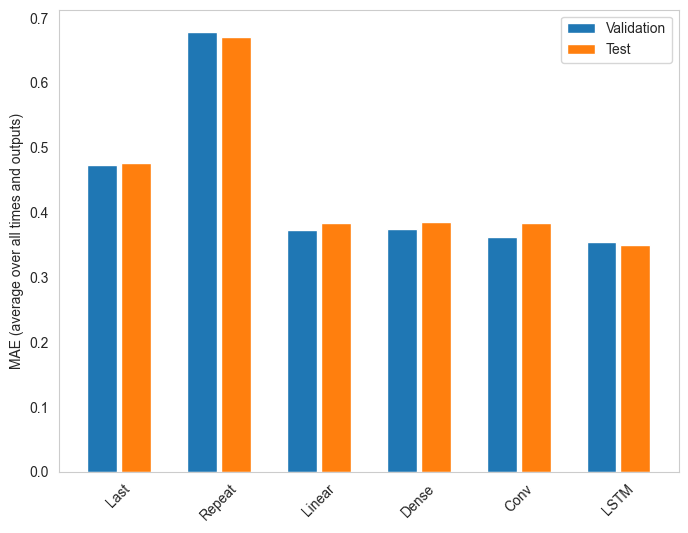

In [147]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [148]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.4756
Repeat  : 0.6696
Linear  : 0.3839
Dense   : 0.3843
Conv    : 0.3835
LSTM    : 0.3491
